## Libraries / Setup

In [347]:
pip install plotly wordcloud

Note: you may need to restart the kernel to use updated packages.


In [348]:
conda install -c plotly plotly-orca

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [367]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings('ignore')

## Init Dataframe

In [368]:
df = pd.read_csv("starwars_ebay/starwars_ebay.csv")
df.head()

,product_name,price,country,condition,shipping_cost,demand_status,url
0,🔥Star Wars Vintage Collection ARC Commander Ha...,$32.90,from Malaysia,Brand New,+$18.00 shipping,Last one,https://www.ebay.com/itm/144937682104?hash=ite...
1,Star Wars Vintage Collection Mandalorian Super...,$19.99,from United States,Brand New,+$13.35 shipping,85 sold,https://www.ebay.com/itm/394251731939?epid=190...
2,Star Wars Vintage Collection Dark Trooper (The...,$28.99,from United States,Brand New,+$18.70 shipping,71 watchers,https://www.ebay.com/itm/125700558379?hash=ite...
3,Star Wars Vintage Collection Deathwatch Mandal...,$15.49,from United States,Brand New,+$13.28 shipping,Almost gone,https://www.ebay.com/itm/125636022875?hash=ite...
4,STAR WARS Vintage Collection VC34 Jango Fett A...,$141.50,from United States,Brand New,+$25.17 shipping,NaN,https://www.ebay.com/itm/295529080278?hash=ite...


### Fields/Columns

In [369]:
df.columns

Index(['product_name', 'price', 'country', 'condition', 'shipping_cost',
       'demand_status', 'url'],
      dtype='object')

In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_name   10020 non-null  object
 1   price          10020 non-null  object
 2   country        10020 non-null  object
 3   condition      10020 non-null  object
 4   shipping_cost  10019 non-null  object
 5   demand_status  1842 non-null   object
 6   url            10020 non-null  object
dtypes: object(7)
memory usage: 548.1+ KB


### Null Values

In [371]:
df.isna().sum()

product_name        0
price               0
country             0
condition           0
shipping_cost       1
demand_status    8178
url                 0
dtype: int64

In [372]:
n_df = len(df["product_name"])
print(f"Total records in df: {n_df}")

Total records in df: 10020


In [373]:
demand_status_nan_perc = df["demand_status"].isna().sum() / n_df
print(f"demand_status has the highest NaNs in dataset ({round(100*demand_status_nan_perc, 2)}%)")

demand_status has the highest NaNs in dataset (81.62%)


_We can see that **demand_status** has the highest NaNs in the dataset but we'll leave it like that to see if we can get some extra insights for when we do have demand statuses available_

## Data Cleaning

### Categoricals

#### Country

In [374]:
# check if all columns have the "from" str
country_len = len(df["country"])
print(f"total records in country: {country_len}")

total records in country: 10020


In [375]:
from_counter = 0
for index, row in df.iterrows():
    if "from" in row["country"]:
        from_counter += 1

print(f"total rows with 'from' string in country columb: {from_counter}")

total rows with 'from' string in country columb: 10020


In [376]:
df["country"] = df["country"].map(lambda x: x.strip("from "))
df.head()

,product_name,price,country,condition,shipping_cost,demand_status,url
0,🔥Star Wars Vintage Collection ARC Commander Ha...,$32.90,Malaysia,Brand New,+$18.00 shipping,Last one,https://www.ebay.com/itm/144937682104?hash=ite...
1,Star Wars Vintage Collection Mandalorian Super...,$19.99,United States,Brand New,+$13.35 shipping,85 sold,https://www.ebay.com/itm/394251731939?epid=190...
2,Star Wars Vintage Collection Dark Trooper (The...,$28.99,United States,Brand New,+$18.70 shipping,71 watchers,https://www.ebay.com/itm/125700558379?hash=ite...
3,Star Wars Vintage Collection Deathwatch Mandal...,$15.49,United States,Brand New,+$13.28 shipping,Almost gone,https://www.ebay.com/itm/125636022875?hash=ite...
4,STAR WARS Vintage Collection VC34 Jango Fett A...,$141.50,United States,Brand New,+$25.17 shipping,NaN,https://www.ebay.com/itm/295529080278?hash=ite...


In [377]:
country_freqs = df.country.value_counts()
df_country_freqs = pd.DataFrame(country_freqs).reset_index()
df_country_freqs.head()

,index,country
0,United States,9031
1,Australia,429
2,Taiwan,208
3,Canada,166
4,Japan,59


#### Condition

In [378]:
# get frequency of conditions
condition_freqs = df.condition.value_counts()
df_condition_freqs = pd.DataFrame(condition_freqs).reset_index()
df_condition_freqs

,index,condition
0,Brand New,8671
1,Pre-Owned,1349


### Product Name

In [379]:
# undercase all strings in product_name
df["product_name"] = df["product_name"].str.lower()

def plot_treemap(df):
    fig = px.treemap(df[0:100], path=[px.Constant("star wars vintage collection ebay"), 'word'],
                    values='count',
                    color='count',
                    color_continuous_scale='viridis',
                    color_continuous_midpoint=np.average(df['count'])
                    )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show(renderer="png")

In [380]:
# get all unique words from product row
unique_words = list(df["product_name"].str.split(" ", expand=True).stack().unique())
# unique_words

In [381]:
value_counts = df["product_name"].str.split(" ", expand=True).stack().value_counts()
df_common_words = pd.DataFrame(value_counts).reset_index()
df_common_words = df_common_words.rename(columns={
    "index": "word",
    0: "count"
})
df_common_words.head()

,word,count
0,wars,10297
1,star,10031
2,vintage,9789
3,collection,9482
4,the,4231


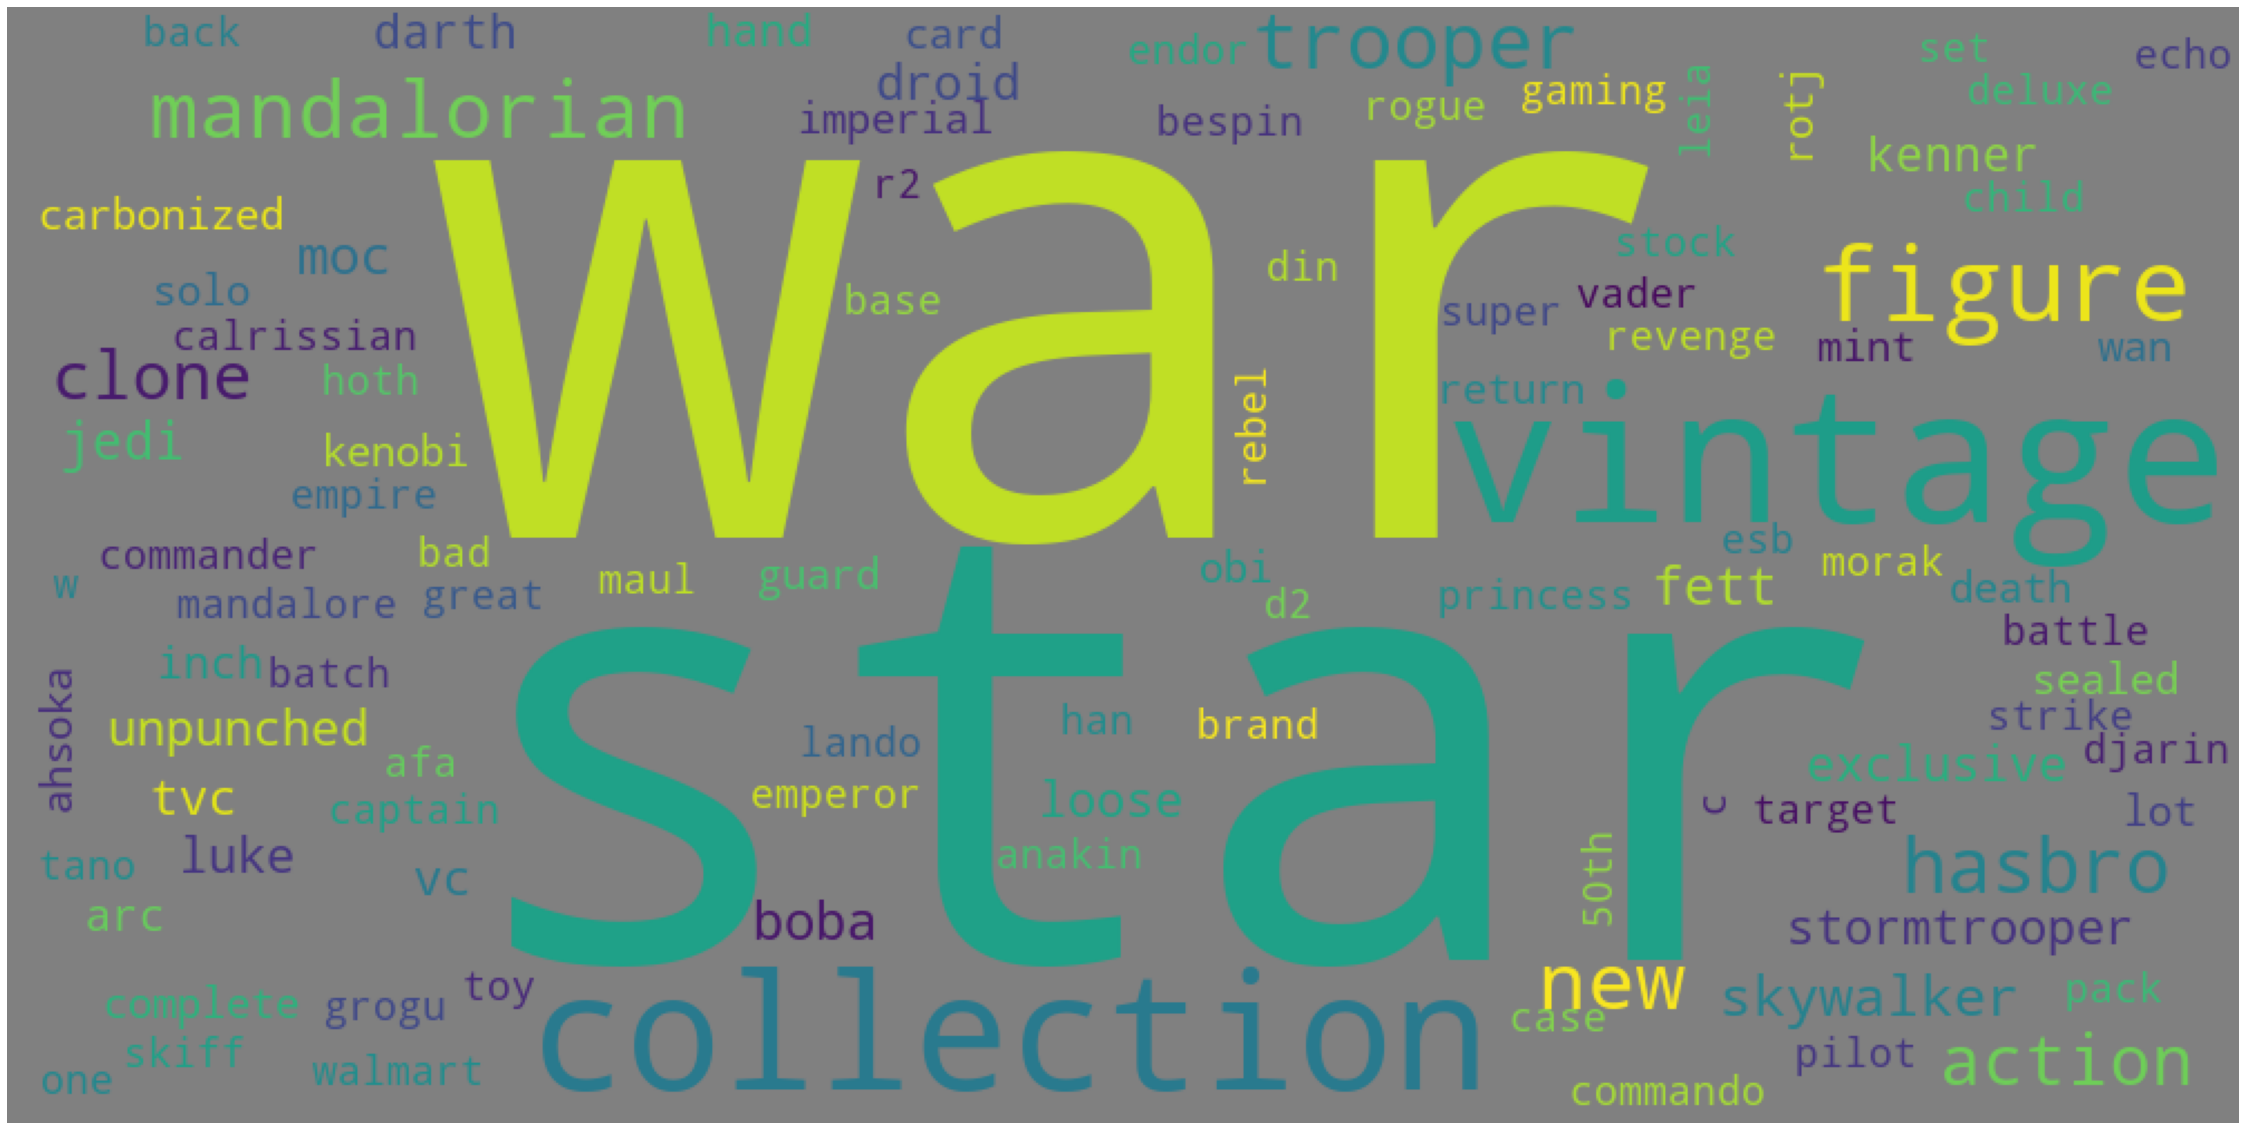

In [382]:
list_product_name = df["product_name"].to_list()
str_product_name = " ".join(list_product_name)
wordcloud = WordCloud(width=1000, height=500, max_words=100,
                      random_state=1, background_color='gray', colormap='viridis_r',
                      collocations=False, stopwords = STOPWORDS).generate(str_product_name)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [383]:
plot_treemap(df_common_words)

KeyboardInterrupt: 

In [384]:
# replicate the img above but removing the expected words
to_rmv = ["star", "wars", "vintage", "collection", "the", "-", "new", '3.75"', "3.75", "of", ""]
df_common_words_excl = df_common_words[df_common_words["word"].isin(to_rmv) == False]
plot_treemap(df_common_words_excl)

KeyboardInterrupt: 

#### Demand Status

In [385]:
# get unique values from demand_status
print(df["demand_status"].unique())

['Last one' '85 sold' '71 watchers' 'Almost gone' nan '26 sold'
 '12 watchers' '15 watchers' '34 watchers' 'Buy It Now' '5 watchers'
 '73 watchers' '25 watchers' '15 sold' '9 watchers' '95 watchers'
 '5+ watchers' '20 sold' '30 watchers' '69 watchers' '17 watchers'
 '66+ sold' '11 sold' '13 watchers' '14 watchers' '18 watchers'
 '60 watchers' '4 watchers' '74 watchers' '7 watchers' '29 watchers'
 '120 watchers' '10 watchers' '33 sold' '6 watchers' '16+ watchers'
 '22 watchers' '36 watchers' '33 watchers' '20 watchers' '56 watchers'
 '45+ sold' '37 watchers' '41 sold' '2 watchers' '156 watchers'
 '16 watchers' '48 watchers' '19 watchers' '11 watchers' '3 watchers'
 '137 watchers' '31 watchers' '45 watchers' '68 watchers' '21 watchers'
 '28 watchers' '50+ sold' '24 watchers' '8 watchers' '27 watchers'
 '51 watchers' '23 watchers' '42 watchers' '2+ watchers' '38 watchers'
 '32 watchers' '14 sold' '95 sold' '30+ sold' '26 watchers' '53 watchers'
 '62 sold' '31+ sold' '134 sold' '50 watcher

In [420]:
# simplify demand_status by grouping # of watchers & # sold
df["demand_status_ints"] = df.demand_status.str.extract("(\d+)")
df["demand_status_ints"] = df["demand_status_ints"].fillna(0)
df["demand_status"] = df["demand_status"].fillna("missing")
df["demand_status_ints"] = df["demand_status_ints"].astype(int)
df_sort = df.sort_values(by=["demand_status_ints"], ascending=False)
df_sort.head(10)

,product_name,price,country,condition,shipping_cost,demand_status,url,demand_status_ints,temp,demand_status_final
6455,star wars vintage collection the mandalorian v...,$30.00,United States,Brand New,+$19.75 shipping,481 sold,https://www.ebay.com/itm/333729342016?epid=230...,481,481 sold,481 sold
1088,star wars legacy vintage collection millennium...,$9.50,United States,Brand New,+$17.19 shipping,181 sold,https://www.ebay.com/itm/313310796080?hash=ite...,181,181 sold,181 sold
230,"star wars vintage collection 3.75""figure vehic...",$164.99,United States,Brand New,+$115.85 shipping,156 watchers,https://www.ebay.com/itm/224329604595?epid=270...,156,156 watchers,156 watchers
277,hasbro star wars vintage collection jabba's sa...,"$9,999.99",United States,Brand New,"+$2,833.06 shipping",137 watchers,https://www.ebay.com/itm/333256280814?hash=ite...,137,137 watchers,137 watchers
857,2021 star wars vintage collection vc202 ahsoka...,$16.99,United States,Brand New,+$17.52 shipping estimate,134 sold,https://www.ebay.com/itm/384417404396?epid=504...,134,134 sold,134 sold
1546,new star wars vintage collection boba fett rot...,$59.95,United States,Brand New,+$13.95 shipping,122 sold,https://www.ebay.com/itm/133792550234?hash=ite...,122,122 sold,122 sold
131,star wars clone wars vc247 vintage collection ...,$17.99,United States,Brand New,+$15.98 shipping estimate,120 watchers,https://www.ebay.com/itm/304645913017?epid=505...,120,120 watchers,120 watchers
5910,gi joe retro series or star wars vintage colle...,$18.99,United States,Brand New,+$25.54 shipping,103 sold,https://www.ebay.com/itm/255248899319?hash=ite...,103,103 sold,103 sold
2831,custom jabba's palace door fits star wars vint...,$9.99,United States,Brand New,+$22.91 shipping,100 watchers,https://www.ebay.com/itm/184941741110?hash=ite...,100,100 watchers,100 watchers
1639,custom jabbas palace door fits star wars vinta...,$6.99,United States,Brand New,+$22.87 shipping,99 watchers,https://www.ebay.com/itm/184937455241?hash=ite...,99,99 watchers,99 watchers


We can use a max of 100 for items sold or watchers left as max number is 99 in col

In [428]:
dmnd_status_final, ds_groups = [], [20, 40, 60, 80, 100]
for index, row in df.iterrows():
    if "watchers" in row["demand_status"]:
        if row["demand_status_ints"] > ds_groups[-1]:
                dmnd_status_final.append(f"~100+ watchers")
        else:
            for group in ds_groups:
                if row["demand_status_ints"] <= group:
                    dmnd_status_final.append(f"~{group} watchers")
                    break
    elif "sold" in row["demand_status"]:
        if row["demand_status_ints"] > ds_groups[-1]:
                dmnd_status_final.append(f"~100+ sold")
        else:
            for group in ds_groups:
                if row["demand_status_ints"] <= group:
                    dmnd_status_final.append(f"~{group} sold")
                    break
    else:
        dmnd_status_final.append(row["demand_status"])
print(f"length of new list: {len(dmnd_status_final)}")
df["demand_status_final"] = dmnd_status_final
print(df["demand_status_final"].unique())

length of new list: 10020
['Last one' '~100 sold' '~80 watchers' 'Almost gone' 'missing' '~40 sold'
 '~20 watchers' '~40 watchers' 'Buy It Now' '~20 sold' '~100 watchers'
 '~80 sold' '~60 watchers' '~100+ watchers' '~60 sold' '~100+ sold']


In [431]:
# get frequency of demand_status
demand_status_freqs = df.demand_status_final.value_counts()
df_demand_status_freqs = pd.DataFrame(demand_status_freqs).reset_index()
df_demand_status_freqs = df_demand_status_freqs.rename(
    columns={"index": "demand_status", "demand_status_final": "count"}
)
# excl missing to show most relevant demand_status
df_demand_status_freqs = df_demand_status_freqs[df_demand_status_freqs["demand_status"] != "missing"]
df_demand_status_freqs

,demand_status,count
1,~20 watchers,1012
2,Last one,510
3,~40 watchers,119
4,Almost gone,45
5,Buy It Now,45
6,~20 sold,25
7,~60 watchers,20
8,~40 sold,19
9,~60 sold,16
10,~80 watchers,9


### **Numericals**

#### Price

In [ ]:
dollar_counter = 0
for index, row in df.iterrows():
    if "$" in row["price"]:
        dollar_counter += 1

print(f"total rows with '$' string in country columb: {dollar_counter}")

total rows with '$' string in country columb: 10020


In [ ]:
df["price"] = df["price"].map(lambda x: x.strip("$").replace(",","")).astype(float)
df.head()

,product_name,price,country,condition,shipping_cost,demand_status,url
0,🔥Star Wars Vintage Collection ARC Commander Ha...,32.90,Malaysia,Brand New,+$18.00 shipping,Last one,https://www.ebay.com/itm/144937682104?hash=ite...
1,Star Wars Vintage Collection Mandalorian Super...,19.99,United States,Brand New,+$13.35 shipping,85 sold,https://www.ebay.com/itm/394251731939?epid=190...
2,Star Wars Vintage Collection Dark Trooper (The...,28.99,United States,Brand New,+$18.70 shipping,71 watchers,https://www.ebay.com/itm/125700558379?hash=ite...
3,Star Wars Vintage Collection Deathwatch Mandal...,15.49,United States,Brand New,+$13.28 shipping,Almost gone,https://www.ebay.com/itm/125636022875?hash=ite...
4,STAR WARS Vintage Collection VC34 Jango Fett A...,141.50,United States,Brand New,+$25.17 shipping,NaN,https://www.ebay.com/itm/295529080278?hash=ite...


In [ ]:
# search example to check if strips worked properly
search = "Hasbro Star Wars Vintage Collection Jabba's Sail Barge Khetanna with YAK FACE "
df[df["product_name"] == search]

,product_name,price,country,condition,shipping_cost,demand_status,url
277,Hasbro Star Wars Vintage Collection Jabba's Sa...,9999.99,United States,Brand New,"+$2,833.06 shipping",137 watchers,https://www.ebay.com/itm/333256280814?hash=ite...


#### Shipping Cost

In [ ]:
def final_shipping(row):
    if "$" in row["shipping_cost"]:
        return row["shipping_cost_"]
    else:
        return row["pre_final_shipping_cost"]
# # lowercase strings in column
df["shipping_cost"] = df["shipping_cost"].str.lower()
df["shipping_cost"] = df["shipping_cost"].fillna("missing")
# # count all states for shipping: shipping=0, not specified, and has a price ($)
free_shipping_count, shipping_price_count, shipping_na_count, missing_count = 0, 0, 0, 0
for index, row in df.iterrows():
    if "free" in row["shipping_cost"]:
        free_shipping_count += 1
    elif "not specified" in row["shipping_cost"]:
        shipping_na_count += 1
    elif "$" in row["shipping_cost"]:
        shipping_price_count += 1
    else:
        missing_count += 1
print(f"- has shipping price = {shipping_price_count}\n- shipping price not specified = {shipping_na_count}\n- free shipping = {free_shipping_count}\n- missing (nan) = {missing_count}")

- has shipping price = 9837
- shipping price not specified = 153
- free shipping = 29
- missing (nan) = 1


In [ ]:
# create new column for free shipping cost
df["is_shipping_free"] = np.where(df.shipping_cost.str.contains("free"), 1, 0)
# when shipping cost is free then set price to 0
# df["new_shipping_cost"] = np.where(df["is_shipping_free"] == 1, 0, df["shipping_cost"])
# df with shipping price only to formar & join later
df_with_shipping_p = df[df.shipping_cost.str.contains("+$", regex=False)]
df_with_shipping_p["shipping_cost"] = df_with_shipping_p["shipping_cost"].map(lambda x: x.strip("+$")\
    .replace(",","").replace("shipping","").replace("estimate","")).astype(float)
# get shipping cost mean to replace in missing vals & not specified
shipping_cost_mean = df_with_shipping_p["shipping_cost"].mean()
# create df to join rows with actual shipping cost
df_with_shipping_index = df_with_shipping_p[["shipping_cost"]]
df_with_shipping_index = df_with_shipping_index.rename(columns={"shipping_cost": "shipping_cost_"})
print(f"mean = {shipping_cost_mean}")
# df_with_shipping_index

mean = 24.306725627732156


In [ ]:
# create new final col by looping through different types
new_ship_price = []
for index, row in df.iterrows():
    if "free" in row["shipping_cost"]:
        new_ship_price.append(0)
    elif "$" in row["shipping_cost"]:
        # keep it as it is to later change it merging df by index
        new_ship_price.append(row["shipping_cost"])
    elif "not specified" or "missing" in row["shipping_cost"]:
        new_ship_price.append(shipping_cost_mean)
df["pre_final_shipping_cost"] = new_ship_price
df = df.join(df_with_shipping_index)
df["shipping_cost_formatted"] = df.apply(lambda row: final_shipping(row), axis=1)
df.head()

,product_name,price,country,condition,shipping_cost,demand_status,url,is_shipping_free,pre_final_shipping_cost,shipping_cost_,shipping_cost_formatted
0,🔥Star Wars Vintage Collection ARC Commander Ha...,32.90,Malaysia,Brand New,+$18.00 shipping,Last one,https://www.ebay.com/itm/144937682104?hash=ite...,0,+$18.00 shipping,18.00,18.00
1,Star Wars Vintage Collection Mandalorian Super...,19.99,United States,Brand New,+$13.35 shipping,85 sold,https://www.ebay.com/itm/394251731939?epid=190...,0,+$13.35 shipping,13.35,13.35
2,Star Wars Vintage Collection Dark Trooper (The...,28.99,United States,Brand New,+$18.70 shipping,71 watchers,https://www.ebay.com/itm/125700558379?hash=ite...,0,+$18.70 shipping,18.70,18.70
3,Star Wars Vintage Collection Deathwatch Mandal...,15.49,United States,Brand New,+$13.28 shipping,Almost gone,https://www.ebay.com/itm/125636022875?hash=ite...,0,+$13.28 shipping,13.28,13.28
4,STAR WARS Vintage Collection VC34 Jango Fett A...,141.50,United States,Brand New,+$25.17 shipping,NaN,https://www.ebay.com/itm/295529080278?hash=ite...,0,+$25.17 shipping,25.17,25.17
